# Marketing Mix Modelling (MMM) with Google Meridian — Bikes (Demo)

**Goal:** Estimate *incremental* contribution of paid media channels to weekly sales and derive budget recommendations under constraints.

**Important:** This is a **demonstration dataset**. Results are illustrative. This workflow is for **decision support / incrementality**, not KPI forecasting.


## 1) Setup & Imports

In [ ]:
# Install Meridian (Colab)
# If you're running locally and already have it, you can comment this out.
!pip -q install --upgrade google-meridian[colab,and-cuda,schema]

import os
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.keras.backend.set_floatx("float64")  # Avoid float32/float64 mismatches in TFP

from meridian.analysis import analyzer, optimizer, summarizer, visualizer
from meridian.analysis.review import reviewer
from meridian.data import data_frame_input_data_builder
from meridian.model import model, spec
from schema.serde import meridian_serde
from meridian.analysis import visualizer


import IPython

import warnings
warnings.filterwarnings("ignore", message=".*aggregate_geos.*ignored.*")
warnings.filterwarnings("ignore", message=".*Effectiveness is not reported.*")
warnings.filterwarnings("ignore", message=".*use_kpi=True.*no effect.*")
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")



## 2) Load data + basic data contract

Expected columns:
- `Week` (weekly date)
- `sales` (weekly revenue or sales KPI)
- media spend columns (e.g., `tv_spend`, `facebook_spend`, etc.)


In [ ]:
# Robust path handling (Colab default vs local)
DATA_PATH = "/content/bike_sales_data.csv"
if not os.path.exists(DATA_PATH):
    DATA_PATH = "bike_sales_data.csv"  # fallback

df = pd.read_csv(DATA_PATH)
df.head()


,Week,sales,branded_search_spend,nonbranded_search_spend,facebook_spend,print_spend,ooh_spend,tv_spend,radio_spend
0,7/23/17,58850.0,1528.8,463.32,802.620,0,0,0,0
1,7/30/17,62050.0,1575.6,468.00,819.312,0,0,0,0
2,8/6/17,59388.0,1544.4,477.36,749.034,0,0,0,0
3,8/13/17,56964.0,1528.8,468.00,741.468,0,0,0,0
4,8/20/17,53460.0,1560.0,458.64,811.200,0,0,0,0


In [ ]:
# Define paid media channels (spend-only demo)
media_cols = [
    'branded_search_spend', 'nonbranded_search_spend', 'facebook_spend',
    'print_spend', 'ooh_spend', 'tv_spend', 'radio_spend'
]

# Parse time and add geo column required by Meridian
df['Week'] = pd.to_datetime(df['Week'], errors='coerce')
df = df.dropna(subset=['Week']).sort_values('Week').reset_index(drop=True)
df['national'] = 'national'

# Ensure numeric types are float64 (very important for TFP stability)
num_cols = ['sales'] + media_cols
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df[num_cols] = df[num_cols].fillna(0).astype('float64')

df[num_cols].describe().T[['mean','std','min','max']].head(10)


/tmp/ipython-input-1177638800.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Week'] = pd.to_datetime(df['Week'], errors='coerce')


,mean,std,min,max
sales,68107.553558,19608.831323,29088.000,113762.880
branded_search_spend,2033.680231,902.962242,1375.920,7800.000
nonbranded_search_spend,402.383740,200.049791,229.320,1093.693
facebook_spend,1015.262797,453.045170,660.231,3900.000
print_spend,376.923077,487.533935,0.000,1500.000
ooh_spend,188.461538,391.834536,0.000,1000.000
tv_spend,278.846154,788.512244,0.000,2500.000
radio_spend,523.076923,1033.906896,0.000,3000.000


## 3) Quick EDA (sanity checks)

Keep it light: trend/seasonality and spend mix.


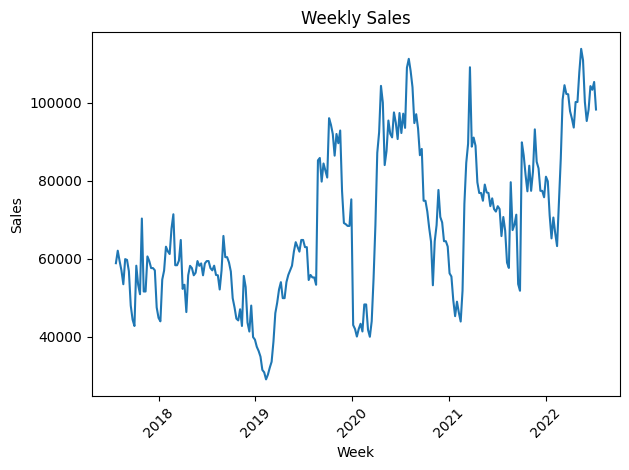

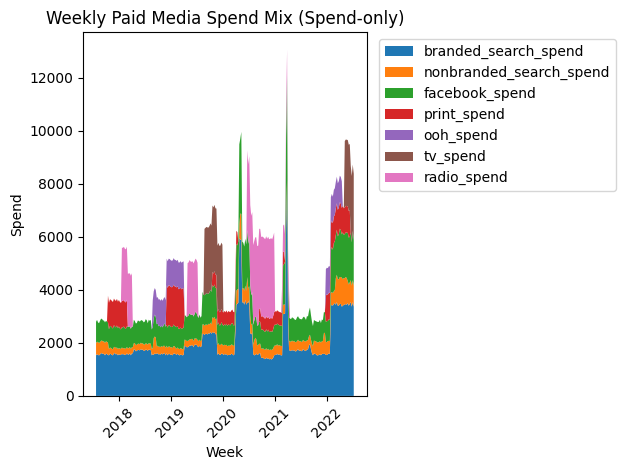

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df['Week'], df['sales'])
plt.title('Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.stackplot(df['Week'], *[df[c] for c in media_cols], labels=media_cols)
plt.title('Weekly Paid Media Spend Mix (Spend-only)')
plt.xlabel('Week')
plt.ylabel('Spend')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()
plt.show()


## 4) Baseline controls (trend + seasonality)

A common reason for **negative baseline** is over-attribution to treatments when trend/seasonality (and other drivers) are missing.
We add simple time controls that are safe for MMM (no leakage).


In [ ]:
# Time controls: trend + Fourier seasonality (annual + semi-annual)
t = np.arange(len(df), dtype='float64') #creates: 0, 1, 2, 3… up to N-1. the “passage of time” (a linear trend).
df['trend_t'] = t

# week-of-year for Fourier terms
#It is the input for building (sine/cosine) waves that capture seasonality.
woy = df['Week'].dt.isocalendar().week.astype(int).to_numpy() #Convert the week date to the week number of the year: 1..52/53.

# approximation of the length of the year in weeks (365.25/7 ≈ 52.18).

df['sin_52'] = np.sin(2 * np.pi * woy / 52.18)
df['cos_52'] = np.cos(2 * np.pi * woy / 52.18)#one cycle per year (approx. 52 weeks)

#26.09 is half.
df['sin_26'] = np.sin(2 * np.pi * woy / 26.09)
df['cos_26'] = np.cos(2 * np.pi * woy / 26.09) #two cycles per year (semi-annual)

control_cols = ['trend_t', 'sin_52', 'cos_52', 'sin_26', 'cos_26'] #to pass to the builder "these are my control variables".
df[control_cols] = df[control_cols].astype('float64') #TFP/Meridian usually operates on float64

df[control_cols].head()


,trend_t,sin_52,cos_52,sin_26,cos_26
0,0.0,-0.343277,-0.939234,0.644835,0.764322
1,1.0,-0.453615,-0.891198,0.808521,0.588467
2,2.0,-0.557384,-0.830255,0.925541,0.378647
3,3.0,-0.653080,-0.757289,0.989141,0.146972
4,4.0,-0.739319,-0.673355,0.995649,-0.093185


## 5) Build Meridian `InputData`

In [ ]:
builder = data_frame_input_data_builder.DataFrameInputDataBuilder(
    kpi_type='revenue',
    default_kpi_column='sales',
    default_time_column='Week',
    default_geo_column='national',
)

builder.with_kpi(df, kpi_col='sales', time_col='Week', geo_col='national')

# Spend-only demo: we pass spends both as media and spend denominators
builder.with_media(
    df,
    media_cols=media_cols,
    media_spend_cols=media_cols,
    media_channels=media_cols,
)

# baseline drivers (time/seasonality), and does not force the spend to "pay for everything".
if hasattr(builder, "with_controls"):
    builder.with_controls(df, control_cols=control_cols)
else:
    print("⚠️ Your Meridian build does not support with_controls(). Skipping controls.")

input_data = builder.build()
input_data


/usr/local/lib/python3.12/dist-packages/meridian/data/input_data.py:517: UserWarning: Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.
  warnings.warn(


InputData(kpi=<xarray.DataArray 'kpi' (geo: 1, time: 260)> Size: 2kB
array([[ 58850.    ,  62050.    ,  59388.    ,  56964.    ,  53460.    ,
         59896.    ,  59692.    ,  56800.    ,  48000.    ,  44400.    ,
         42768.    ,  58212.    ,  53328.    ,  50904.    ,  70296.    ,
         51600.    ,  51600.    ,  60588.    ,  59400.    ,  57600.    ,
         57600.    ,  57024.    ,  47520.    ,  44844.    ,  43956.    ,
         54648.    ,  56964.    ,  63084.    ,  61896.    ,  61200.    ,
         67752.    ,  71388.    ,  58332.    ,  58332.    ,  59520.    ,
         64800.    ,  52272.    ,  53328.    ,  46332.    ,  55752.    ,
         58176.    ,  57600.    ,  55752.    ,  56400.    ,  59400.    ,
         58176.    ,  58800.    ,  55752.    ,  58800.    ,  59400.    ,
         59400.    ,  57600.    ,  57024.    ,  58212.    ,  55836.    ,
         55752.    ,  52116.    ,  57024.    ,  65836.    ,  60400.    ,
         60400.    ,  59040.    ,  56721.6   ,  49896. 

## 6) Model spec (optional holdout) + training

We add a random 20% holdout to get Train/Test fit guidance (still **not** forecasting).

I used a 20% random holdout to assess generalisation. Train and test fit were similar, suggesting limited overfitting and more reliable ROI/response curve estimates.

* Goal: check stability (overfitting). We fit the model without ~20% of weeks
and evaluate fit on those unseen weeks. Similar Train/Test metrics => more reliable insights.


In [ ]:
## Holdout (Train/Test guidance) — NOT forecasting

# We randomly hold out ~20% of time periods to sanity-check generalisation.
# This is not "future prediction"; it’s a robustness check within the historical window.

np.random.seed(1)  # reproducible split
n_times = len(df["Week"].unique())  # number of distinct weekly periods

# Boolean mask: False = train, True = holdout/test
holdout_id = np.full([n_times], False)

# Randomly select 20% of weeks as holdout (no replacement)
n_holdout = int(np.round(0.20 * n_times))
holdout_idx = np.random.choice(n_times, n_holdout, replace=False)
holdout_id[holdout_idx] = True


## Version-safe ModelSpec

# Meridian API differs across versions; some support `holdout_id` in ModelSpec.
# We only pass it if the parameter exists to avoid runtime errors.

spec_kwargs = {}
sig = inspect.signature(spec.ModelSpec)

if "holdout_id" in sig.parameters:
    spec_kwargs["holdout_id"] = holdout_id

model_spec = spec.ModelSpec(**spec_kwargs)

# Build MMM model object
mmm = model.Meridian(input_data=input_data, model_spec=model_spec)


/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:75: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


### Optional: Prior sampling (non-blocking)

Useful for diagnosing whether priors allow unrealistically large contributions.
If it fails in your environment, we skip without stopping the notebook.


In [ ]:
try:
    _ = mmm.sample_prior(n_draws=500)
    print("✅ Prior sampling completed.")
except Exception as e:
    print("⚠️ Prior sampling skipped (non-blocking). Reason:")
    print(repr(e))


### Posterior sampling (MCMC)

In [ ]:
# Posterior Sampling (adjust if you need faster runs)
mmm.sample_posterior(
    n_chains=4,
    n_adapt=500,
    n_burnin=500,
    n_keep=500,
)
print("✅ Training completed.")


## 7) Diagnostics & Quality checks

In [ ]:
# Quality checks (recommended)
qc = reviewer.ModelReviewer(mmm).run()
qc


### How to interpre reviewer results
* **Convergence:** PASS → MCMC likely converged (R-hat < 1.2).
* **Baseline:** REVIEW (0.31) → occasional small negative baseline dips; reviewer   explicitly says inspect visually, don’t overreact.
* **PPP:** PASS (0.54) → observed total outcome is consistent with posterior predictive distribution.
* **Fit**: PASS → R² ~0.77 and wMAPE ~0.11 are strong for a demo.
* **Prior–Posterior shift:** PASS → the data is informative; the model learned.

In [ ]:
# Model fit (visual)
viz = visualizer.ModelFit(mmm)
viz.plot_model_fit()



“ModelReviewer flagged baseline negativity as REVIEW (P(baseline<0)=0.31). Visual inspection of the baseline series shows only occasional minor dips, which is acceptable for this demonstration dataset.”

In [ ]:
#2) Convergence Diagnostics (R-hat + other checks)
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()




What this chart is

This is an R-hat convergence diagnostic from Bayesian MCMC.
* Each box corresponds to a parameter group (e.g., adstock alpha_m, saturation ec_m, slope, baseline terms, etc.).
* The y-axis is R-hat.
* The red line at 1.0 is “perfect agreement” between chains.

If chains have converged, they all look like they’re sampling from the same posterior distribution, so R-hat stays close to 1.0.
* Good: boxes sitting very close to 1.0 (e.g., 1.00–1.05).
* Watch: values creeping towards 1.1.
* Problem: values ≥ 1.2 (Meridian’s reviewer uses this as the typical “likely not converged” threshold).

## 8) Results & Insights (contribution, ROI, saturation)

In [ ]:
from meridian.analysis import visualizer

# --- Media summary (contribution + ROI) ---
ms = visualizer.MediaSummary(mmm)

# 1) Contribution overview (best for stakeholders)
ms.plot_contribution_waterfall_chart()
ms.plot_contribution_pie_chart()

# 2) Contribution over time (tells the story of mix changes)
ms.plot_channel_contribution_area_chart()
# Optional (nice but not mandatory)
# ms.plot_channel_contribution_bump_chart()

# 3) ROI (core decision metric)
ms.plot_roi_bar_chart()
# Optional scatter diagnostics
ms.plot_roi_vs_mroi()
# ms.plot_roi_vs_effectiveness()

# 4) Spend vs contribution (checks over-attribution intuitively)
ms.plot_spend_vs_contribution()


# --- Media effects (adstock + saturation / diminishing returns) ---
me = visualizer.MediaEffects(mmm)

# 5) Adstock decay (carryover)
me.plot_adstock_decay()

# 6) Saturation + response curves (diminishing returns)
me.plot_hill_curves()
me.plot_response_curves()


Model quality: PASS (with review). Convergence and fit checks passed. Baseline negativity flagged for review (P=0.31); visual inspection shows only occasional minor dips, consistent with small statistical error in a demonstration dataset.

## 9) Budget optimisation + export HTML reports

In [ ]:
# Output folder
meridian_root = "meridian_results"
os.makedirs(meridian_root, exist_ok=True)

# Model summary (2-page HTML)
summ = summarizer.Summarizer(mmm)
try:
    summ.output_model_results_summary(filepath=meridian_root, filename="final_report_bicycles.html")
    IPython.display.HTML(filename=os.path.join(meridian_root, "final_report_bicycles.html"))
except TypeError:
    # Fallback signature used in some examples
    start_date = str(df['Week'].min().date())
    end_date   = str(df['Week'].max().date())
    summ.output_model_results_summary("summary_output.html", meridian_root, start_date, end_date)
    IPython.display.HTML(filename=os.path.join(meridian_root, "summary_output.html"))


In [ ]:
# Budget optimisation
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

# Export optimisation report (method name differs across versions)
if hasattr(optimization_results, "output_optimization_summary"):
    optimization_results.output_optimization_summary("optimization_output.html", meridian_root)
    IPython.display.HTML(filename=os.path.join(meridian_root, "optimization_output.html"))
else:
    print("⚠️ optimization_results.output_optimization_summary not found in this build.")
    print("You can still inspect optimization_results directly:")
    optimization_results


## 10) Save model artifact (optional)

In [ ]:
file_path = os.path.join(meridian_root, "bikes_mmm.binpb")
meridian_serde.save_meridian(mmm, file_path)
print(f"✅ Model saved to: {file_path}")


## Conclusions & next steps

- Quality checks: PASS (baseline flagged for visual review only). The model provides stable Train/Test fit and actionable response curves.

- To productionise: add business drivers (price/promo, availability), apply realistic optimisation constraints, and calibrate with incrementality tests where possible.